In [65]:
%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [66]:
import sys
import cv2
import numpy as np
import _pickle as cPickle
import bz2
from numba import jit
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
from skimage.feature import local_binary_pattern
from skimage.transform import rescale
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path
from IPython.display import clear_output
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import _pickle as cPickle
import bz2

In [68]:
def parseJAFFEName(filename):
    parts = filename.split('.')
    name, emotion = parts[0], parts[1]
    return name, emotion[:2]

In [69]:
def save(filename, myobj):
    """
    save object to file using pickle
    
    @param filename: name of destination file
    @type filename: str
    @param myobj: object to save (has to be pickleable)
    @type myobj: obj
    """

    try:
        f = bz2.BZ2File(filename, 'wb')
    except (IOError, details):
        sys.stderr.write('File ' + filename + ' cannot be written\n')
        sys.stderr.write(details)
        return

    cPickle.dump(myobj, f)
    f.close()



def load(filename):
    """
    Load from filename using pickle
    
    @param filename: name of file to load from
    @type filename: str
    """

    try:
        f = bz2.BZ2File(filename, 'rb')
    except (IOError, details):
        sys.stderr.write('File ' + filename + ' cannot be read\n')
        sys.stderr.write(details)
        return

    myobj = cPickle.load(f)
    f.close()
    return myobj

In [70]:
def cropFace(image):
    faceClassifier = cv2.CascadeClassifier('./haarcascade/haarcascade_frontalface_alt.xml')
    faces = faceClassifier.detectMultiScale(image)
    #get first face coordinates
    xFace, yFace, wFace, hFace = faces[0]
    croppedFace = image[yFace:yFace+hFace, xFace:xFace+wFace]
    return croppedFace

In [71]:
def kirsch(image):
    return {
         "N" : cv2.filter2D(image, -1, np.array([[-3, -3, -3],
                                                 [-3,  0, -3],
                                                 [ 5,  5,  5]
                                                ])),
        "NE" : cv2.filter2D(image, -1, np.array([[-3, -3, -3],
                                                 [ 5,  0, -3],
                                                 [ 5,  5, -3]
                                                ])),
         "E" : cv2.filter2D(image, -1, np.array([[5, -3, -3],
                                                 [5,  0, -3],
                                                 [5, -3, -3]
                                                ])),
        "SE" : cv2.filter2D(image, -1, np.array([[ 5,  5, -3],
                                                 [ 5,  0, -3],
                                                 [-3, -3, -3]
                                                ])),
         "S" : cv2.filter2D(image, -1, np.array([[ 5,  5,  5],
                                                 [-3,  0, -3],
                                                 [-3, -3, -3]
                                                ])),
        "SW" : cv2.filter2D(image, -1, np.array([[-3,  5,  5],
                                                 [-3,  0,  5],
                                                 [-3, -3, -3]
                                                ])),
         "W" : cv2.filter2D(image, -1, np.array([[-3, -3, 5],
                                                 [-3,  0, 5],
                                                 [-3, -3, 5]
                                                ])),
        "NW" : cv2.filter2D(image, -1, np.array([[-3, -3, -3],
                                                 [-3,  0,  5],
                                                 [-3,  5,  5]
                                                ]))
    }

In [72]:
@jit(nopython=True)
def generatePattern(matrix):
    return matrix[0, 0] + (matrix[0, 1]<<1) + (matrix[0, 2]<<2) + (matrix[1, 2]<<3) + \
           (matrix[2, 2]<<4) + (matrix[2, 1]<<5) + (matrix[2, 0]<<6) + (matrix[1, 0]<<7)

In [ ]:
img =  cv2.imread('images/test.png', 0)
# plt.imshow(img, cmap='gray', vmax=255, vmin=0)
# plt.show()
img = cv2.equalizeHist(img)
img = cv2.bilateralFilter(img, 5, 30, 20)
img = cropFace(img)
# plt.imshow(img, cmap='gray', vmax=255, vmin=0)
# plt.show()
# result = np.zeros_like(img)
for key, value in kirsch(img).items():
#     result = np.maximum(result, value)
    res = hvnLBPWithoutBorders(value)
    plt.imshow(res, cmap='gray', vmax=255, vmin=0)
    plt.show()
# plt.imshow(result, cmap='gray', vmax=255, vmin=0)
# plt.show()
# lbp = hvnLBPWithoutBorders(result)
# plt.imshow(lbp, cmap='gray', vmax=255, vmin=0)
# plt.show()


In [74]:
# %lprun -f hvnLBPWithoutBorders hvnLBPWithoutBorders(img)
# @jit(nopython=True)
def hvnLBPWithoutBorders(image):
    height, width = image.shape
    newImage = np.empty([height -2, width -2], dtype=np.uint8)
#     newImage = np.empty((height -2)*(width -2), dtype=np.uint8).reshape((height -2), (width -2))
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            mat = image[i-1:i+2, j-1:j+2].copy()
            mat[1, 1] = 0
            #vertical LBP
            vmat = mat == mat.max(axis=0).reshape(1, 3)
            #horizontal LBP
            hmat = mat == mat.max(axis=1).reshape(3, 1)
            
            hv = np.maximum(vmat, hmat)
            newImage[i-1, j-1] = generatePattern(hv)
    return newImage

In [18]:
@jit(nopython=True)
def LBPH(LBPImg, gridX, gridY):
    cellWidth = LBPImg.shape[1] // gridX
    cellHeight = LBPImg.shape[0] // gridY
    
    feature = np.array((), dtype=np.uint8)
    for x in range(0, gridX*cellWidth, cellWidth):
        for y in range(0, gridY*cellHeight, cellHeight):
            # extract cell
            subImg = LBPImg[y:y+cellHeight, x:x+cellWidth]
            # construct histogram
            hist, bin_edge = np.histogram(subImg.ravel(), bins=256)
            # concatenate histograms
            feature = np.concatenate((feature, hist.astype(np.uint8)))
    return feature

In [19]:
# %lprun -f extractFeature extractFeature( cv2.imread('images/test2.png', 0) )
def extractFeature(image):
    # preprocessing
    image = cv2.equalizeHist(image)
    image = cv2.bilateralFilter(image, 5, 30, 20)    
    image = cropFace(image)
    
    # rescale to 77x77 ( compute on 75x75 without the borders )
    image = rescale(image, 77.0/image.shape[0], anti_aliasing=True, multichannel=False)
    filteredImages = kirsch(image)
    features = np.array([], dtype=np.uint8)
    for filteredImage in filteredImages.values():
        hvn = hvnLBPWithoutBorders(filteredImage)
        lb = LBPH(hvn, 25, 25)
        features = np.concatenate((features, lb))
    return features

In [30]:
directoryPath = "/home/jad/Téléchargements/jaffe"
imgsPaths = glob(directoryPath + '/*.tiff')

features = []
labels = []
index = 1

for imgPath in imgsPaths:
    features.append(extractFeature(cv2.imread(imgPath, 0)))
    filename = Path(imgPath).name
    _personName, emotion = parseJAFFEName(filename)
    labels.append(emotion)
    clear_output(wait=True)
    print("%d/%d"%(index, len(imgsPaths)), filename, emotion)
    index = index + 1
features = np.array(features, dtype=np.uint8)

213/213 TM.AN1.190.tiff AN


In [62]:
directoryPath = "/home/jad/Téléchargements/jaffe"
imgsPaths = glob(directoryPath + '/*.tiff')
JAFFE = []
for imgPath in imgsPaths:
    filename = Path(imgPath).name
    personName, emotion = parseJAFFEName(filename)
    image = cv2.imread(imgPath, 0)
    JAFFE.append([personName, emotion, image])
save('JAFFE', JAFFE)

In [ ]:
features = load('processed')
labels = load('labels')

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.33)
print(len(xtrain), ytrain)
print(len(xtest), ytest)

142 ['SU', 'SA', 'NE', 'FE', 'NE', 'HA', 'AN', 'SU', 'AN', 'HA', 'DI', 'DI', 'NE', 'SA', 'SA', 'AN', 'NE', 'DI', 'AN', 'NE', 'SA', 'SU', 'AN', 'AN', 'NE', 'SU', 'AN', 'SA', 'NE', 'DI', 'HA', 'NE', 'DI', 'SA', 'HA', 'SU', 'HA', 'NE', 'SU', 'SA', 'FE', 'FE', 'AN', 'SU', 'AN', 'SA', 'SA', 'DI', 'SU', 'HA', 'SA', 'AN', 'FE', 'SU', 'DI', 'NE', 'NE', 'SU', 'SU', 'SU', 'FE', 'SU', 'NE', 'NE', 'NE', 'SA', 'HA', 'AN', 'SA', 'SU', 'HA', 'HA', 'SU', 'SA', 'HA', 'HA', 'FE', 'SU', 'AN', 'SA', 'FE', 'HA', 'FE', 'SA', 'DI', 'DI', 'FE', 'NE', 'HA', 'SU', 'HA', 'NE', 'FE', 'AN', 'NE', 'SU', 'AN', 'AN', 'SU', 'HA', 'SA', 'SU', 'FE', 'AN', 'AN', 'FE', 'NE', 'DI', 'FE', 'HA', 'FE', 'HA', 'SA', 'FE', 'AN', 'SA', 'HA', 'NE', 'NE', 'HA', 'HA', 'AN', 'FE', 'DI', 'HA', 'DI', 'HA', 'DI', 'DI', 'DI', 'AN', 'SA', 'SU', 'DI', 'SA', 'SU', 'DI', 'DI', 'FE', 'NE', 'FE', 'NE']
71 ['SA', 'HA', 'DI', 'SA', 'FE', 'DI', 'SU', 'FE', 'AN', 'FE', 'AN', 'SA', 'SA', 'FE', 'NE', 'NE', 'FE', 'FE', 'DI', 'DI', 'AN', 'HA', 'DI', '

In [23]:
# create and train our classifier
svc = OneVsRestClassifier(SVC(random_state=0, decision_function_shape='ovr', C=0.002, kernel='rbf',  gamma=0.0000001))
svc.fit(xtrain, ytrain)

OneVsRestClassifier(estimator=SVC(C=0.002, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.33)
svc = OneVsRestClassifier(SVC(random_state=0, decision_function_shape='ovr', C=0.002, kernel='rbf',  gamma=0.0000001))
51/71 71.83098591549296

In [24]:
totalnum = len(xtest)
correct = 0
for i in range(totalnum):
    prediction = svc.predict(xtest[i].reshape(1, -1))
    print(prediction[0], ytest[i], prediction[0] == ytest[i])
    if prediction[0] == ytest[i]:
        correct +=1
print(correct, totalnum, correct*100/totalnum)

NE SA False
HA HA True
DI DI True
FE SA False
FE FE True
DI DI True
SU SU True
DI FE False
AN AN True
FE FE True
SA AN False
AN SA False
DI SA False
SU FE False
NE NE True
FE NE False
SA FE False
FE FE True
DI DI True
DI DI True
DI AN False
HA HA True
DI DI True
NE NE True
DI AN False
DI DI True
HA SA False
AN AN True
DI DI True
NE NE True
SU SU True
SA SA True
HA HA True
SA SA True
SU SA False
DI DI True
SU SU True
DI DI True
HA HA True
SU SU True
FE FE True
HA HA True
AN AN True
HA HA True
SA FE False
FE FE True
SU SU True
FE SA False
FE FE True
DI FE False
NE NE True
NE AN False
HA HA True
NE NE True
AN AN True
SU SU True
NE NE True
AN AN True
FE SA False
NE AN False
HA HA True
SA SA True
HA HA True
SU SU True
DI FE False
FE FE True
DI FE False
DI DI True
AN DI False
SU SU True
NE NE True
49 71 69.01408450704226


In [13]:
print("%d/%d"%(correct, totalnum), correct*100/totalnum)

51/71 71.83098591549296


(75, 75)


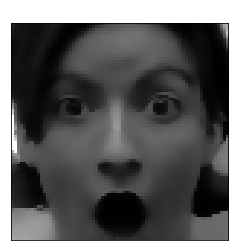

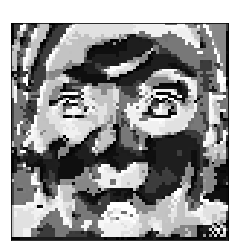

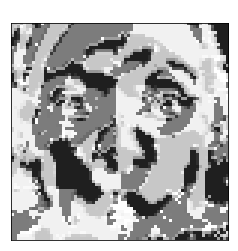

In [22]:
img = cv2.imread('images/test2.png', 0) # load image as grayscale

# preprocessing
img = cv2.equalizeHist(img)
img = cv2.bilateralFilter(img, 20, 25, 25)

img = cropFace(img) # extract face
img = rescale(img, 75.0/img.shape[0], anti_aliasing=False, mode='constant', multichannel=False) # rescale to 75x75
print(img.shape)

plt.imshow(img, cmap='gray')
plt.setp(plt.title('Original preprocessed'), color='w')
plt.xticks([]), plt.yticks([])
plt.show()

lbp = local_binary_pattern(img, 8, 1, 'default')
plt.imshow(lbp, cmap='gray', vmin=0, vmax=255)
plt.setp(plt.title('LBP'), color='w')
plt.xticks([]), plt.yticks([])
plt.show()

res = hvnLBPWithoutBorders(img)

plt.imshow(res, cmap='gray', vmin=0, vmax=255)
plt.setp(plt.title('hvnLBP'), color='w')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
res[res==41]